In [1]:
# STEP 1: Install dependencies
!pip install -q opencv-python scikit-image matplotlib numpy


In [2]:
# STEP 2: Import libraries & helper functions
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, util, restoration
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

plt.rcParams['figure.figsize'] = (6, 6)

def show_img(img, title='Image', cmap='gray'):
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_pair(title, a, b, suptitle=None):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for ax, im, t in zip(axes, [a, b], ['Image A', 'Image B']):
        if im.ndim == 2:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        ax.set_title(t)
        ax.axis('off')
    if suptitle is None:
        suptitle = title
    fig.suptitle(suptitle)
    plt.show()

def to_gray_uint8(img):
    """Ensure grayscale uint8 [0,255]."""
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def rescale_01(img):
    """Return float image in [0,1]."""
    img = img.astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0
    img = np.clip(img, 0.0, 1.0)
    return img

def evaluate_metrics(original, processed):
    """Compute MSE, PSNR, SSIM for grayscale images in [0,255] or [0,1]."""
    # Convert to float in [0,1] for fair comparison
    o = rescale_01(to_gray_uint8(original))
    p = rescale_01(to_gray_uint8(processed))
    mse = mean_squared_error(o, p)
    psnr = peak_signal_noise_ratio(o, p, data_range=1.0)
    ssim = structural_similarity(o, p, data_range=1.0)
    return mse, psnr, ssim


 Please upload TWO images (grayscale preferred). If color, I'll convert to gray automatically.


Saving INDOOR.jpeg to INDOOR.jpeg
Saving OUTDOOR.jpeg to OUTDOOR (1).jpeg


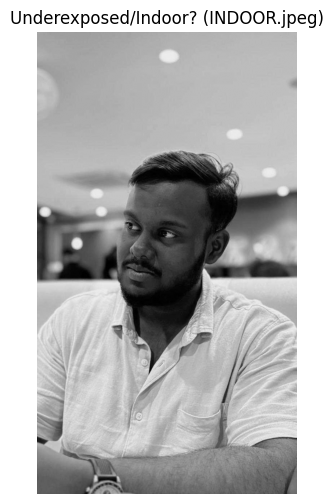

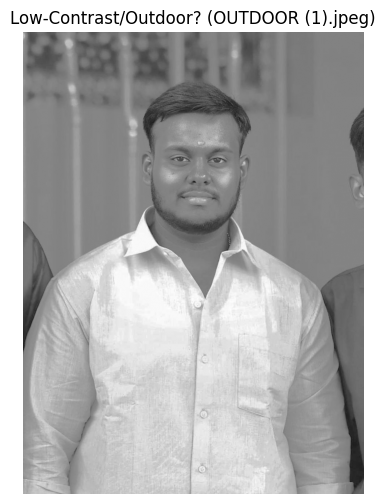

In [5]:
# STEP 3: Upload two images (one underexposed indoor, one low-contrast outdoor)
from google.colab import files
import io
from PIL import Image

print(" Please upload TWO images (grayscale preferred). If color, I'll convert to gray automatically.")
uploaded = files.upload()

# Take first two files
file_names = list(uploaded.keys())
assert len(file_names) >= 2, "Please upload at least 2 images."

img1_name, img2_name = file_names[:2]

def load_image_from_bytes(b):
    arr = np.frombuffer(b, np.uint8)
    im = cv2.imdecode(arr, cv2.IMREAD_COLOR)  # read as color, convert later if needed
    return im

img1_color = load_image_from_bytes(uploaded[img1_name])
img2_color = load_image_from_bytes(uploaded[img2_name])

# Convert to grayscale uint8
img1 = to_gray_uint8(img1_color)
img2 = to_gray_uint8(img2_color)

show_img(img1, f'Underexposed/Indoor? ({img1_name})')
show_img(img2, f'Low-Contrast/Outdoor? ({img2_name})')


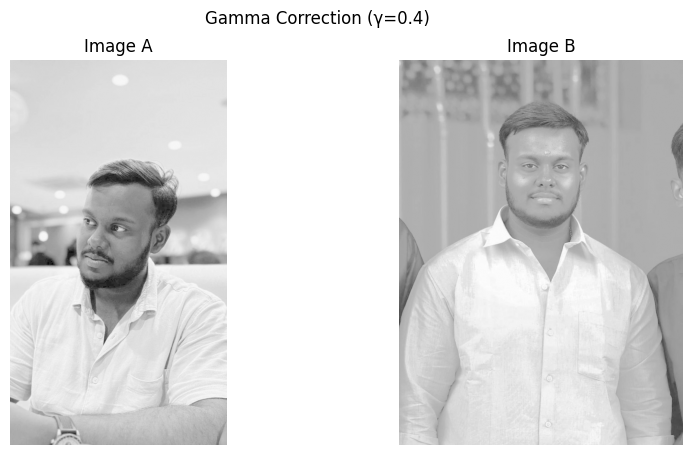

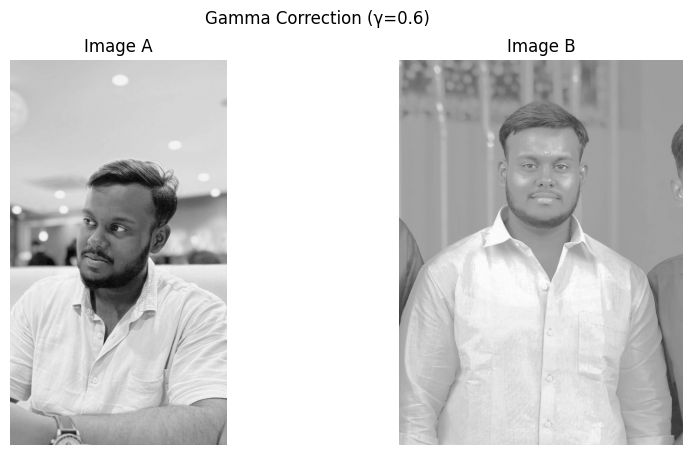

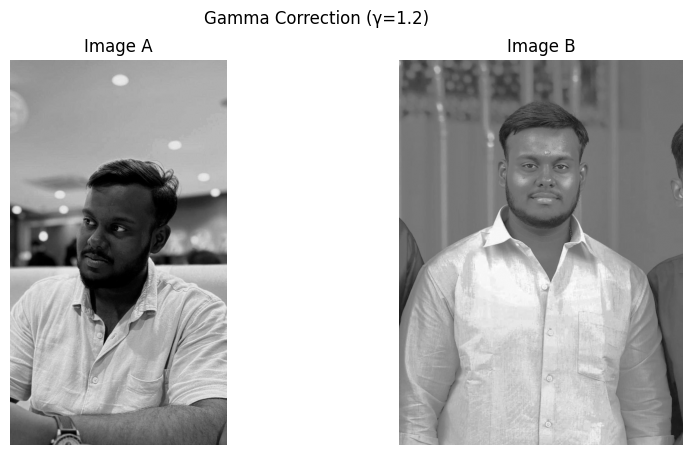

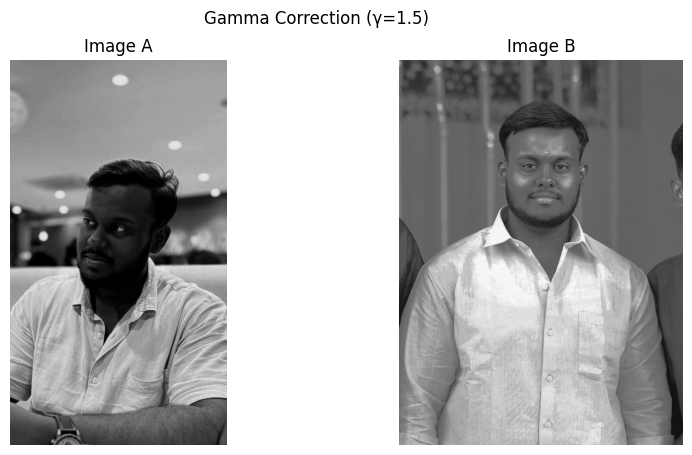

In [6]:
# STEP 4: Gamma Correction
def gamma_correct(img, gamma=1.0):
    # img: uint8 grayscale
    g = max(gamma, 1e-6)
    inv = 1.0 / 255.0
    lut = np.array([((i * inv) ** g) * 255 for i in range(256)]).astype('uint8')
    return cv2.LUT(img, lut)

for g in [0.4, 0.6, 1.2, 1.5]:
    img1_gamma = gamma_correct(img1, g)
    img2_gamma = gamma_correct(img2, g)
    show_pair(f'Gamma Correction (γ={g})', img1_gamma, img2_gamma)


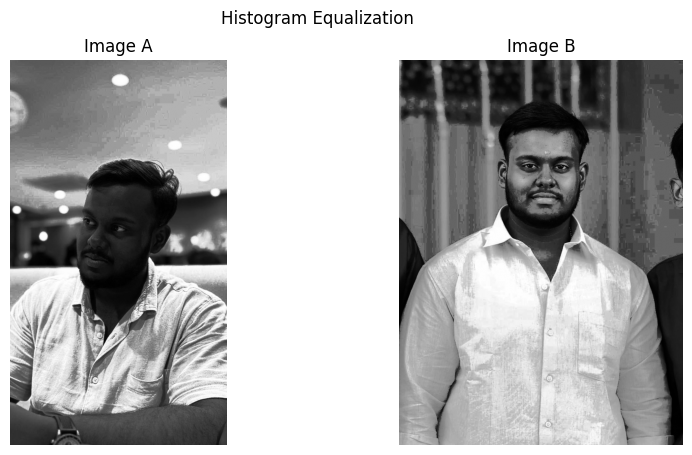

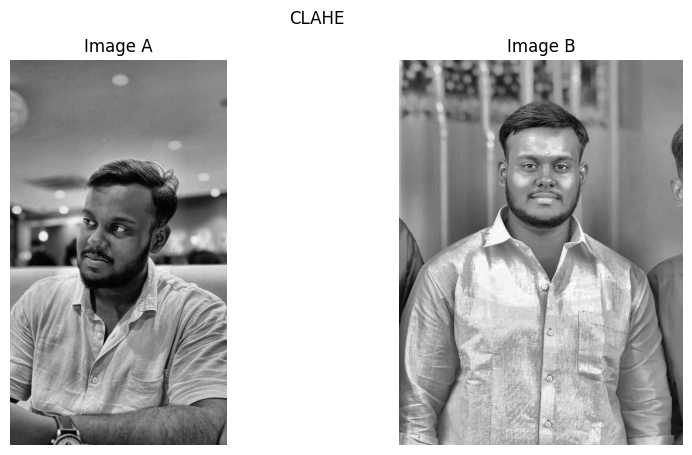

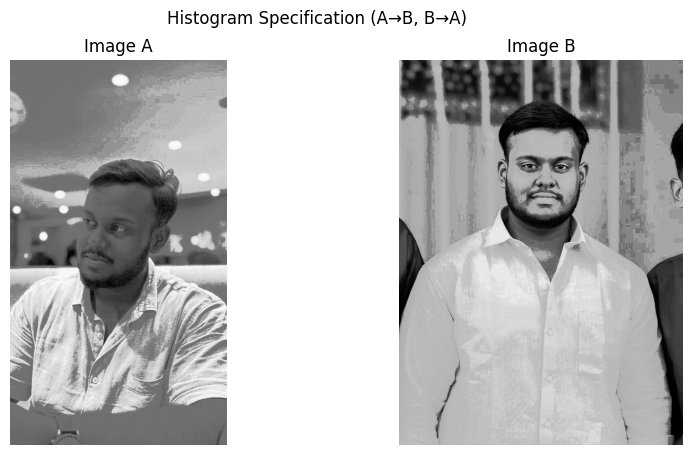

In [7]:
# STEP 5: Histogram Equalization & Specification
# Global Histogram Equalization
img1_eq = cv2.equalizeHist(img1)
img2_eq = cv2.equalizeHist(img2)
show_pair("Histogram Equalization", img1_eq, img2_eq)

# CLAHE (adaptive histogram equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img1_clahe = clahe.apply(img1)
img2_clahe = clahe.apply(img2)
show_pair("CLAHE", img1_clahe, img2_clahe)

# Histogram Specification (match histogram of A to B and vice versa)
# Use skimage.exposure.match_histograms (expects float or uint image)
matched_1 = exposure.match_histograms(img1, img2)
matched_2 = exposure.match_histograms(img2, img1)
# Convert back to uint8 if needed
matched_1 = np.clip(matched_1, 0, 255).astype(np.uint8)
matched_2 = np.clip(matched_2, 0, 255).astype(np.uint8)
show_pair("Histogram Specification (A→B, B→A)", matched_1, matched_2)


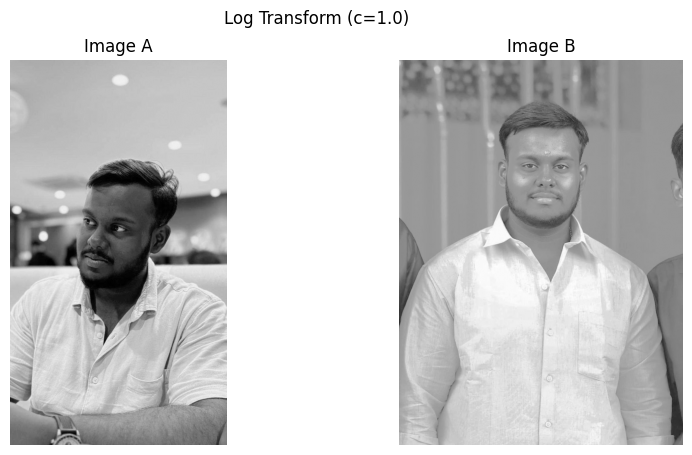

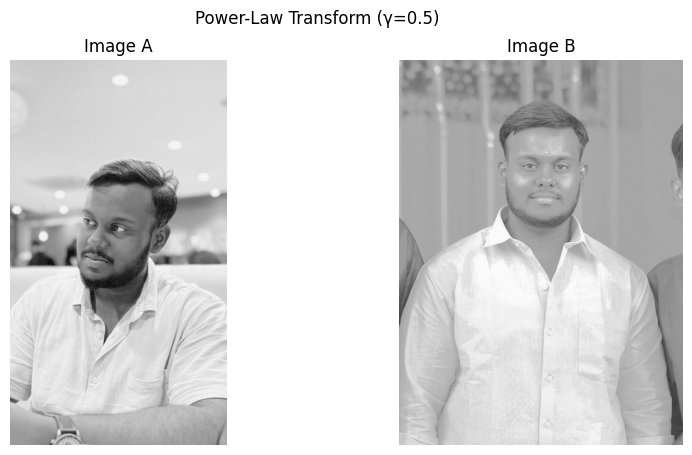

In [8]:
# STEP 6: Logarithmic & Power-Law (Gamma) Transforms

def log_transform(img, c=1.0):
    # img to [0,1], apply log, rescale to [0,255]
    x = rescale_01(img)
    out = c * np.log1p(x) / np.log(2)  # normalized by log(2) for nicer range
    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8)

def power_law(img, gamma=0.5, c=1.0):
    x = rescale_01(img)
    out = c * (x ** gamma)
    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8)

img1_log = log_transform(img1, c=1.0)
img2_log = log_transform(img2, c=1.0)
show_pair("Log Transform (c=1.0)", img1_log, img2_log)

img1_pow = power_law(img1, gamma=0.5)
img2_pow = power_law(img2, gamma=0.5)
show_pair("Power-Law Transform (γ=0.5)", img1_pow, img2_pow)


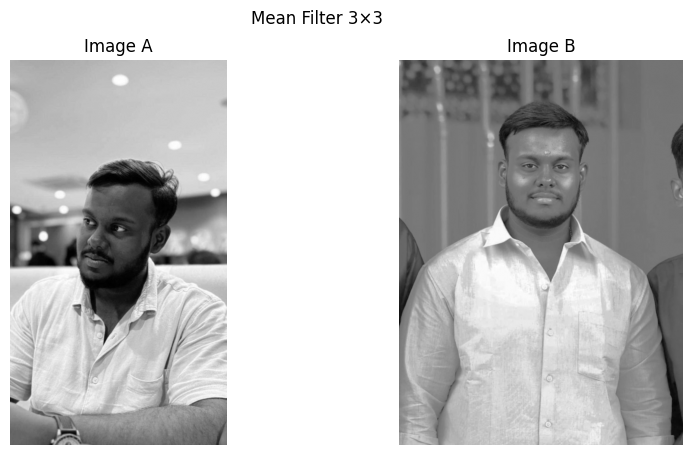

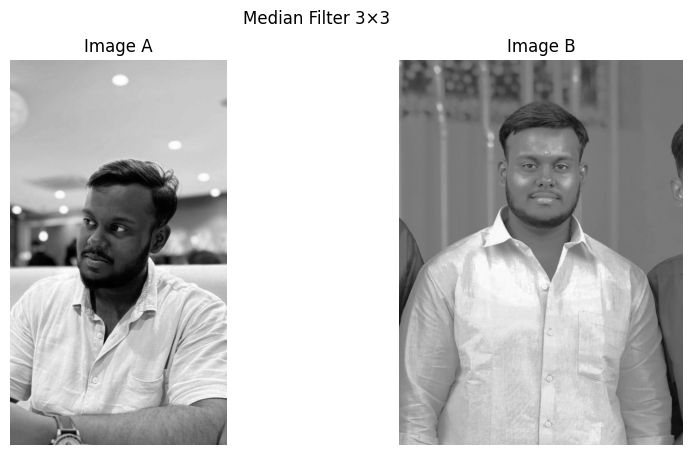

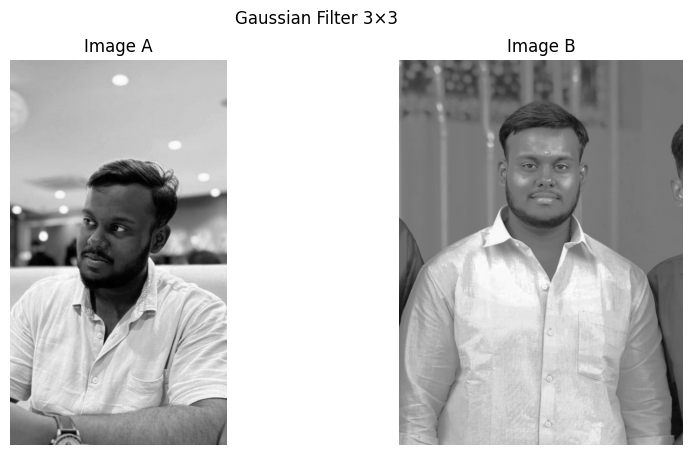

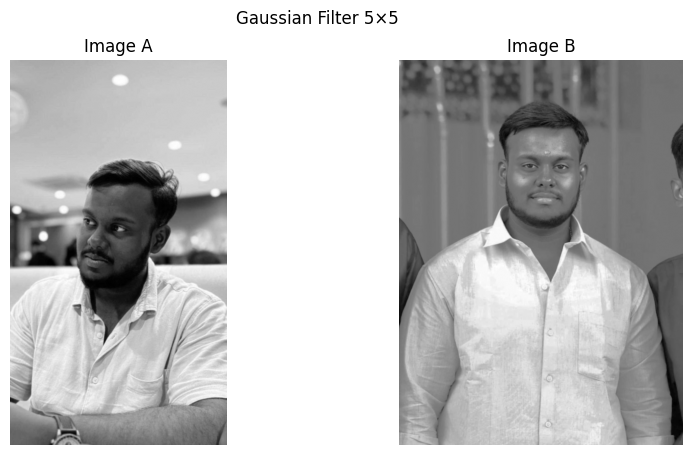

In [9]:
# STEP 7: Spatial Filtering

# Mean (box) filter
img1_mean3 = cv2.blur(img1, (3,3))
img2_mean3 = cv2.blur(img2, (3,3))
show_pair("Mean Filter 3×3", img1_mean3, img2_mean3)

# Median filter (great for salt & pepper)
img1_median = cv2.medianBlur(img1, 3)
img2_median = cv2.medianBlur(img2, 3)
show_pair("Median Filter 3×3", img1_median, img2_median)

# Gaussian filter
img1_gauss3 = cv2.GaussianBlur(img1, (3,3), 0)
img2_gauss3 = cv2.GaussianBlur(img2, (3,3), 0)
show_pair("Gaussian Filter 3×3", img1_gauss3, img2_gauss3)

img1_gauss5 = cv2.GaussianBlur(img1, (5,5), 0)
img2_gauss5 = cv2.GaussianBlur(img2, (5,5), 0)
show_pair("Gaussian Filter 5×5", img1_gauss5, img2_gauss5)


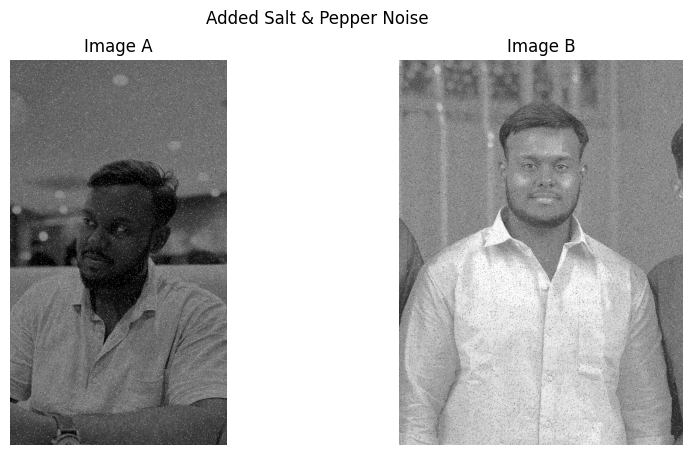

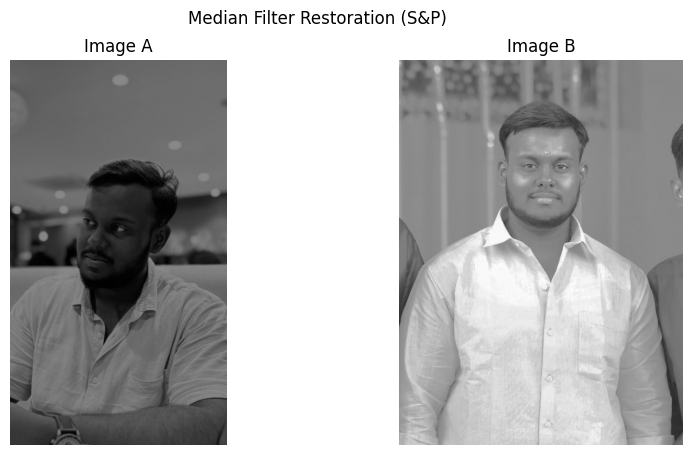

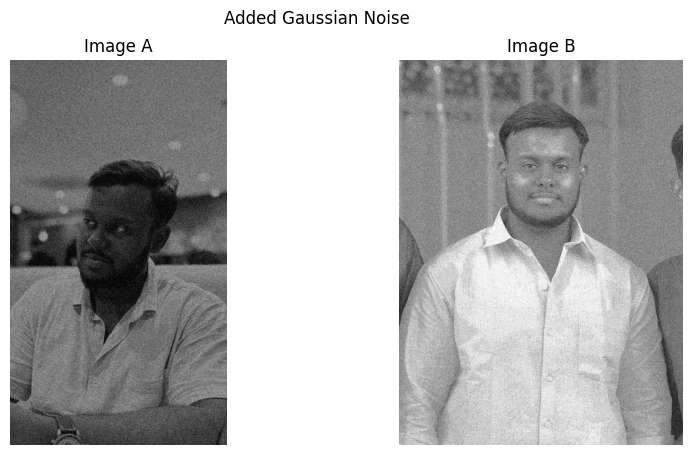

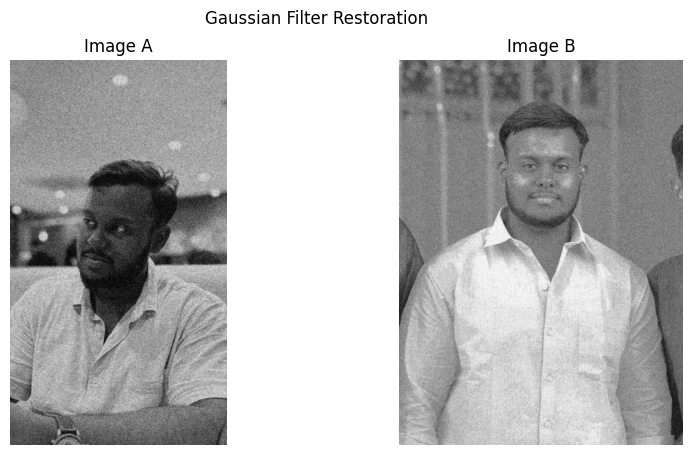

In [10]:
# STEP 8: Add noise & restore

# Work in [0,1] for noise functions
f1 = rescale_01(img1)
f2 = rescale_01(img2)

# Add Salt & Pepper noise
f1_sp = util.random_noise(f1, mode='s&p', amount=0.05)  # 5% impulses
f2_sp = util.random_noise(f2, mode='s&p', amount=0.05)
sp1 = (f1_sp * 255).astype(np.uint8)
sp2 = (f2_sp * 255).astype(np.uint8)
show_pair("Added Salt & Pepper Noise", sp1, sp2)

# Restore S&P via median filter
sp1_med = cv2.medianBlur(sp1, 3)
sp2_med = cv2.medianBlur(sp2, 3)
show_pair("Median Filter Restoration (S&P)", sp1_med, sp2_med)

# Add Gaussian noise
f1_g = util.random_noise(f1, mode='gaussian', var=0.01)
f2_g = util.random_noise(f2, mode='gaussian', var=0.01)
g1 = (f1_g * 255).astype(np.uint8)
g2 = (f2_g * 255).astype(np.uint8)
show_pair("Added Gaussian Noise", g1, g2)

# Restore Gaussian noise via Gaussian filter
g1_rest = cv2.GaussianBlur(g1, (3,3), 0)
g2_rest = cv2.GaussianBlur(g2, (3,3), 0)
show_pair("Gaussian Filter Restoration", g1_rest, g2_rest)


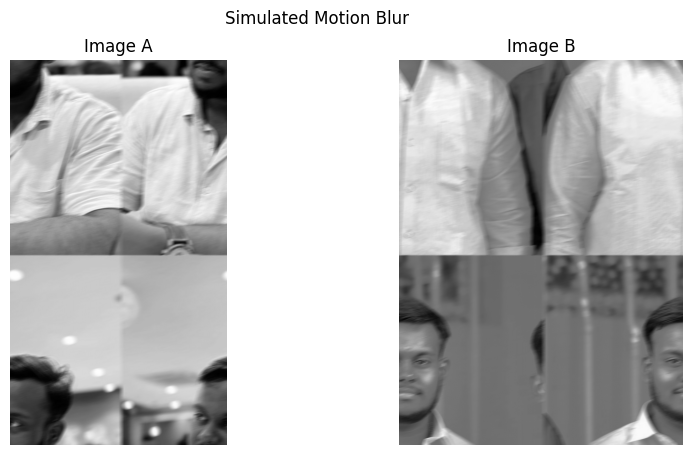

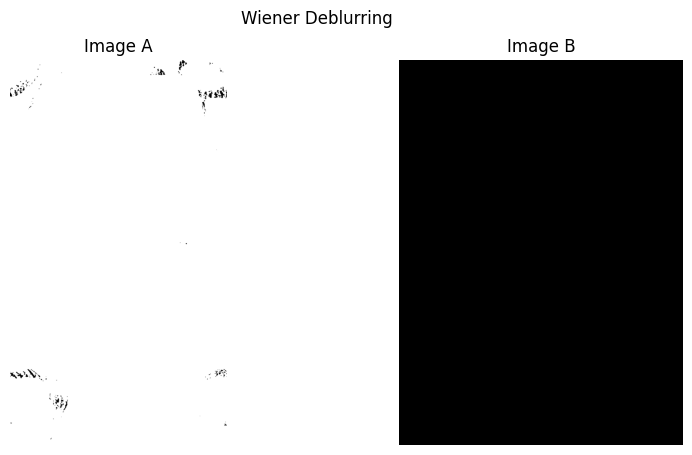

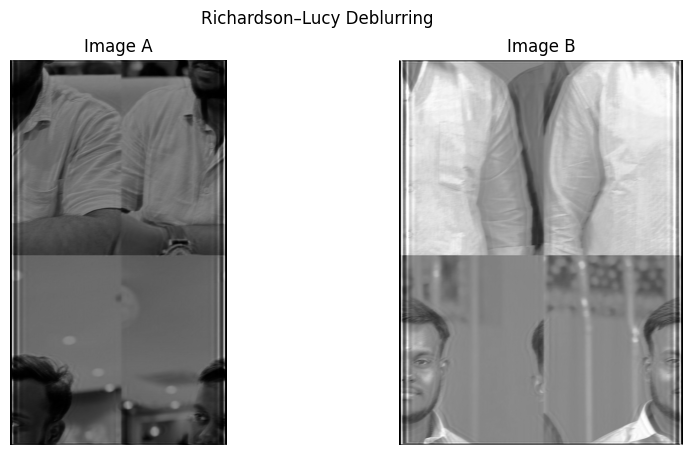

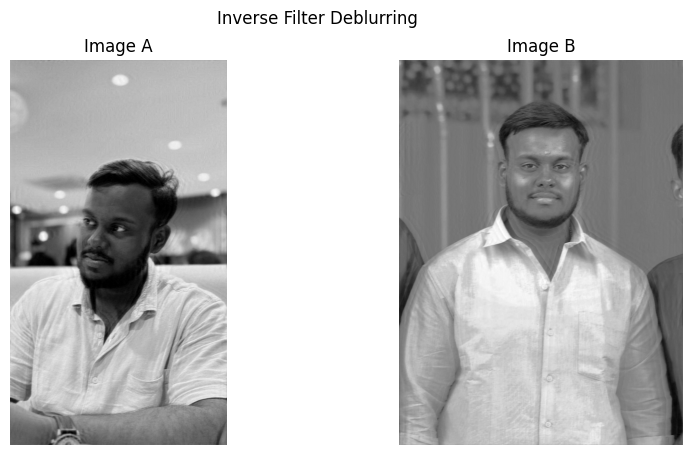

In [11]:
# STEP 9: Deblurring

def motion_psf(length=15, angle=0):
    """Create a simple linear motion blur PSF."""
    psf = np.zeros((length, length), dtype=np.float32)
    center = length // 2
    psf[center, :] = 1.0
    # rotate to given angle
    M = cv2.getRotationMatrix2D((center, center), angle, 1.0)
    psf = cv2.warpAffine(psf, M, (length, length))
    psf /= psf.sum() + 1e-8
    return psf

def convolve2d_freq(img, kernel):
    # zero-pad kernel to image size, then multiply in frequency domain
    H, W = img.shape
    kh, kw = kernel.shape
    pad = np.zeros((H, W), dtype=np.float32)
    pad[:kh, :kw] = kernel
    F = np.fft.fft2(img.astype(np.float32))
    K = np.fft.fft2(np.fft.ifftshift(pad))
    G = F * K
    g = np.fft.ifft2(G).real
    g = np.clip(g, 0, 255)
    return g.astype(np.uint8)

# Create blurred versions (simulate motion blur)
psf = motion_psf(length=19, angle=15)
img1_blur = convolve2d_freq(img1, psf)
img2_blur = convolve2d_freq(img2, psf)
show_pair("Simulated Motion Blur", img1_blur, img2_blur)

# Wiener deconvolution (skimage)
# balance ~ regularization; larger -> smoother result; clip via np.clip
w1 = restoration.wiener(img1_blur.astype(np.float32), psf, balance=0.01, clip=True)
w2 = restoration.wiener(img2_blur.astype(np.float32), psf, balance=0.01, clip=True)
w1 = np.clip(w1, 0, 255).astype(np.uint8)
w2 = np.clip(w2, 0, 255).astype(np.uint8)
show_pair("Wiener Deblurring", w1, w2)

# Richardson–Lucy deconvolution
rl1 = restoration.richardson_lucy(img1_blur.astype(np.float32)/255.0, psf, num_iter=20, clip=True)
rl2 = restoration.richardson_lucy(img2_blur.astype(np.float32)/255.0, psf, num_iter=20, clip=True)
rl1 = np.clip(rl1*255, 0, 255).astype(np.uint8)
rl2 = np.clip(rl2*255, 0, 255).astype(np.uint8)
show_pair("Richardson–Lucy Deblurring", rl1, rl2)

# Simple inverse filter (frequency domain) with epsilon for stability
def inverse_filter(blurred, kernel, eps=1e-3):
    H, W = blurred.shape
    kh, kw = kernel.shape
    pad = np.zeros((H, W), dtype=np.float32)
    pad[:kh, :kw] = kernel
    K = np.fft.fft2(np.fft.ifftshift(pad))
    B = np.fft.fft2(blurred.astype(np.float32))
    K_conj = np.conj(K)
    denom = (np.abs(K)**2 + eps)
    F_hat = B * K_conj / denom
    f = np.fft.ifft2(F_hat).real
    return np.clip(f, 0, 255).astype(np.uint8)

inv1 = inverse_filter(img1_blur, psf, eps=1e-2)
inv2 = inverse_filter(img2_blur, psf, eps=1e-2)
show_pair("Inverse Filter Deblurring", inv1, inv2)


In [13]:
# STEP 10: Evaluation Metrics

def print_metrics_block(title, pairs):
    print(f"\n {title}")
    print(f"{'Method':15s}  {'MSE':>10s}  {'PSNR':>10s}  {'SSIM':>10s}")
    for name, orig, proc in pairs:
        mse, psnr, ssim = evaluate_metrics(orig, proc)
        print(f"{name:15s}  {mse:10.4f}  {psnr:10.2f}  {ssim:10.4f}")

# Choose a few representative transforms/filters for both images
pairs_img1 = [
    ("Gamma0.4", img1, gamma_correct(img1, 0.4)),
    ("HistEq",   img1, cv2.equalizeHist(img1)),
    ("Log",      img1, log_transform(img1)),
    ("Mean3x3",  img1, cv2.blur(img1, (3,3))),
    ("Median3x3",img1, cv2.medianBlur(img1,3))
]

pairs_img2 = [
    ("Gamma0.4", img2, gamma_correct(img2, 0.4)),
    ("HistEq",   img2, cv2.equalizeHist(img2)),
    ("Log",      img2, log_transform(img2)),
    ("Mean3x3",  img2, cv2.blur(img2, (3,3))),
    ("Median3x3",img2, cv2.medianBlur(img2,3))
]

print_metrics_block("Underexposed Image (img1) — metric comparison", pairs_img1)
print_metrics_block("Low-Contrast Image (img2) — metric comparison", pairs_img2)



 Underexposed Image (img1) — metric comparison
Method                  MSE        PSNR        SSIM
Gamma0.4             0.0823       10.84      0.7782
HistEq               0.0558       12.54      0.7735
Log                  0.0057       22.48      0.9762
Mean3x3              0.0001       41.57      0.9737
Median3x3            0.0001       42.60      0.9774

 Low-Contrast Image (img2) — metric comparison
Method                  MSE        PSNR        SSIM
Gamma0.4             0.0423       13.73      0.9095
HistEq               0.0323       14.91      0.7594
Log                  0.0046       23.33      0.9881
Mean3x3              0.0001       41.97      0.9765
Median3x3            0.0000       43.34      0.9808
